In [1]:
# Import all dependencies

from __future__ import print_function
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.callbacks import ModelCheckpoint
from keras import optimizers
import numpy as np

C:\Users\mgond\Anaconda2\envs\ipykernel_py3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Set Parameters

batch_size = 64  # Batch size for training.
epochs = 25  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'deu_new.txt'

In [3]:
# Vectorize the data

input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [4]:
# Find out total samples, unique tokens and max sequence length for both input and target

num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 88
Max sequence length for inputs: 16
Max sequence length for outputs: 53


In [5]:
# Create dictionary for input and target characters
# Create zero arrays of shape (#samples, #max length of input sample word, #unique characters in input)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [6]:
# One-hot encoding for all the arrays

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

# Create Encoder-Decoder Framework

In [7]:
# Define an input sequence and process it.
# Create an encoder LSTM layer

encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [8]:
# Set up the decoder, using `encoder_states` as initial state.

decoder_inputs = Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences and return states to be used in inference

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define model, checkpoints and train the model

In [9]:
# Define the model that will turn `encoder_input_data` & `decoder_input_data` into `decoder_target_data`

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

#optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#optimizer = optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
#optimizer = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
#optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
#optimizer = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 71)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 88)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 256), (None, 335872      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 256),  353280      input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

In [10]:
# Define the checkpoints for storing weights at different epochs and loss values

filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]


In [13]:
# Run training

history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=25,
          callbacks=callbacks_list,
          validation_split=0.2,
          shuffle=True).history

Train on 8000 samples, validate on 2000 samples
Epoch 1/25
8000/8000 [==============================] - 64s 8ms/step - loss: 0.8069 - acc: 0.2477 - val_loss: 0.8647 - val_acc: 0.1882

Epoch 00001: loss improved from inf to 0.80692, saving model to weights-improvement-01-0.8069.hdf5
Epoch 2/25


C:\Users\mgond\Anaconda2\envs\ipykernel_py3\lib\site-packages\keras\engine\topology.py:2364: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


8000/8000 [==============================] - 66s 8ms/step - loss: 0.6774 - acc: 0.1715 - val_loss: 0.7810 - val_acc: 0.1967

Epoch 00002: loss improved from 0.80692 to 0.67741, saving model to weights-improvement-02-0.6774.hdf5
Epoch 3/25
8000/8000 [==============================] - 64s 8ms/step - loss: 0.6154 - acc: 0.1847 - val_loss: 0.7172 - val_acc: 0.2142

Epoch 00003: loss improved from 0.67741 to 0.61542, saving model to weights-improvement-03-0.6154.hdf5
Epoch 4/25
8000/8000 [==============================] - 68s 8ms/step - loss: 0.5664 - acc: 0.2003 - val_loss: 0.6839 - val_acc: 0.2237

Epoch 00004: loss improved from 0.61542 to 0.56636, saving model to weights-improvement-04-0.5664.hdf5
Epoch 5/25
8000/8000 [==============================] - 65s 8ms/step - loss: 0.5315 - acc: 0.2107 - val_loss: 0.6431 - val_acc: 0.2333

Epoch 00005: loss improved from 0.56636 to 0.53151, saving model to weights-improvement-05-0.5315.hdf5
Epoch 6/25
8000/8000 [==============================] -

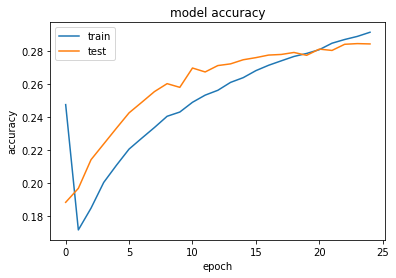

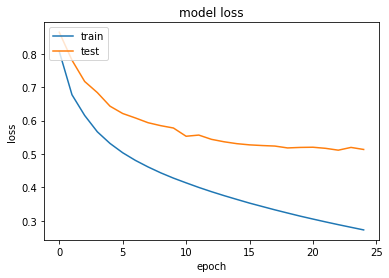

In [15]:
# Draw plots for loss and accuracy for training as well as testing

import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
# load the network weights from the best saved check point checkpoint

filename = "weights-improvement-25-0.2724.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [17]:
# Define sampling models

encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)


In [18]:
# Reverse-lookup token index to decode sequences back to something readable

reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

# Inference

In [19]:
# Define the inference process to actually translate

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

# Speech input

In [41]:
#Speech Recognition
 
import speech_recognition as sr
 
#Sample rate is how often values are recorded
sample_rate = 48000

#Chunk is like a buffer. It stores 2048 samples (bytes of data)
#it is advisable to use powers of 2 such as 1024 or 2048
chunk_size = 2048

#Initialize the recognizer
r = sr.Recognizer()
 
with sr.Microphone(sample_rate = sample_rate, chunk_size = chunk_size) as source:
    #wait for a second to let the recognizer adjust the 
    #energy threshold based on the surrounding noise level
    r.adjust_for_ambient_noise(source)
    print("Say something to translate.")
    #listens for the user's input
    audio = r.listen(source)
         
    try:
        text = r.recognize_google(audio)
        print("You said: " + text)
     
    #error occurs when google could not understand what was said
     
    except sr.UnknownValueError:
        print("Google Speech Recognition could not understand audio")
     
    except sr.RequestError as e:
        print("Could not request results from Google Speech Recognition service; {0}".format(e))

Say something to translate.
You said: I am dumb


In [42]:
encoder_input_data_speech = np.zeros(
    (1, max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')

for t, char in enumerate(text):
    encoder_input_data_speech[0, t, input_token_index[char]] = 1.
    
#speech translation
decoded_sentence_speech = decode_sequence(encoder_input_data_speech)

print('Input sentence:', text)
print('Decoded sentence:', decoded_sentence_speech)

Input sentence: I am dumb
Decoded sentence: Ich bin sehr gewannt.



# Keyboard Input

In [29]:
kb_input = input('Enter a sentence to translate: ')

Enter a sentence to translate: Go away!


In [31]:
encoder_input_data_kb = np.zeros(
    (1, max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')

for t, char in enumerate(kb_input):
    encoder_input_data_kb[0, t, input_token_index[char]] = 1.
    
#input translation
decoded_sentence_kb = decode_sequence(encoder_input_data_kb)

print('Input sentence:', kb_input)
print('Decoded sentence:', decoded_sentence_kb)

Input sentence: Go away!
Decoded sentence: Verschwinde!



# From the corpus

In [53]:
for seq_index in range(5):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Input sentence: Hi.
Decoded sentence: Hallo, Tom!

Input sentence: Hi.
Decoded sentence: Hallo, Tom!

Input sentence: Run!
Decoded sentence: Hör auf zu schreien.

Input sentence: Wow!
Decoded sentence: ollen sich rein!

Input sentence: Wow!
Decoded sentence: ollen sich rein!

Input sentence: Fire!
Decoded sentence: Vergiss es mit!

Input sentence: Help!
Decoded sentence: Hallo, war!

Input sentence: Help!
Decoded sentence: Hallo, war!

Input sentence: Stop!
Decoded sentence: Mach dich vom Acker!

Input sentence: Wait!
Decoded sentence: Warten Sie!

